In [1]:
from pathlib import Path

import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow import keras

In [2]:
class OneHotEncoder:
    def __init__(self, all_category_list, all_ingredient_list):
        self.all_food_categories = all_category_list
        self.all_food_categories.sort()
        self.all_food_categories_integer_encoded = (
            self.__encode_categories_to_integers()
        )
        self.all_ingredients = all_ingredient_list
        self.all_ingredients.sort()
        self.all_ingredients_integer_encoded = self.__encode_ingredients_to_integers()

    def get_category_one_hot_encoding(self, category_name):
        index = self.all_food_categories_integer_encoded[category_name]
        assert index != None, f"{category_name} does not have an integer mapping"
        num_classes = len(self.all_food_categories)
        return keras.utils.to_categorical(index, num_classes)

    def get_ingredients_one_hot_encoding(self, ingredient_list):
        ingredient_list = list(
            map(lambda x: self.__transform_ingredient_to_integer(x), ingredient_list)
        )
        multi_one_hot_layer = tf.keras.layers.CategoryEncoding(
            num_tokens=len(self.all_ingredients), output_mode="multi_hot"
        )
        return multi_one_hot_layer(ingredient_list)

    def __transform_ingredient_to_integer(self, ingredient_name):
        index = self.all_ingredients_integer_encoded[ingredient_name]
        assert index != None, f"{ingredient_name} does not have an integer mapping"
        return index

    def __encode_categories_to_integers(self):
        return {
            category_name: index
            for index, category_name in enumerate(self.all_food_categories)
        }

    def __encode_ingredients_to_integers(self):
        return {
            ingredient_name: index
            for index, ingredient_name in enumerate(self.all_ingredients)
        }

In [3]:
class Recipes5k:
    def __init__(self, load_as_tfdata=False, tfdata_path=None):
        if load_as_tfdata == False:
            self.dir_path = Path("../Food Datasets/final-dataset")
            self.metadata = self.load_recipe5k_metadata()
            self.all_categories = self.extract_all_categories()
            self.all_ingredients = self.extract_all_ingredients()
            self.one_hot_encoder = OneHotEncoder(
                self.all_categories, self.all_ingredients
            )
            self.entire_dataset = self.get_dataset()
        else:
            assert (
                tfdata_path != None
            ), "The path for loading the saved recipes5k as tensorflow dataset is not specified"
            tfdata_path = Path(tfdata_path)
            self.training_dataset = tf.data.experimental.load(str((tfdata_path/"train").resolve()), compression="GZIP")
            self.validation_dataset = tf.data.experimental.load(str((tfdata_path/"validation").resolve()), compression="GZIP")

    def load_image_to_arr(self, path):
        image = tf.keras.preprocessing.image.load_img(path)
        img_tensor = tf.keras.preprocessing.image.img_to_array(image)
        return tf.image.resize(img_tensor, (224, 224))

    def load_recipe5k_metadata(self):
        directory = self.dir_path / "metadata" / "recipes5k_metadata.csv"
        return pd.read_csv(directory, sep="\t").sample(frac=1, random_state=1234)

    def extract_all_categories(self):
        return self.metadata["Category"].unique().tolist()

    def extract_all_ingredients(self):
        unique_ingredients = set()
        for ingredient_list in self.metadata["Ingredients"]:
            ingredient_list = ingredient_list.split(",")
            unique_ingredients.update(ingredient_list)
        return [*unique_ingredients]

    def generate_dataset(self):
        img_dir = self.dir_path / "images"
        for index, row in self.metadata.iterrows():
            img_path = img_dir / row["Category"] / (row["ID/File Name"] + ".jpg")
            img_tensor = self.load_image_to_arr(img_path)
            calorie_tensor = row["Calorie(kcal)"]
            carbs_tensor = row["Carbohydrate(g)"]
            protein_tensor = row["Protein(g)"]
            fat_tensor = row["Fat(g)"]
            one_hot_category_tensor = (
                self.one_hot_encoder.get_category_one_hot_encoding(row["Category"])
            )
            one_hot_ingredient_tensor = (
                self.one_hot_encoder.get_ingredients_one_hot_encoding(
                    row["Ingredients"].split(",")
                )
            )
            yield tf.constant(img_tensor), {
                "category_output": tf.constant(one_hot_category_tensor),
                "calorie_output": tf.constant(calorie_tensor),
                "carbs_output": tf.constant(carbs_tensor),
                "protein_output": tf.constant(protein_tensor),
                "fat_output": tf.constant(fat_tensor),
                "ingredients_output": one_hot_ingredient_tensor,
            }

    def get_dataset(self):
        dataset = tf.data.Dataset.from_generator(
            self.generate_dataset,
            output_signature=(
                tf.TensorSpec(shape=(224, 224, 3), dtype=tf.dtypes.float32),
                {
                    "category_output": tf.TensorSpec(
                        shape=(101), dtype=tf.dtypes.float32
                    ),
                    "calorie_output": tf.TensorSpec(
                        shape=(), dtype=tf.dtypes.float32
                    ),
                    "carbs_output": tf.TensorSpec(
                        shape=(), dtype=tf.dtypes.float32
                    ),
                    "protein_output": tf.TensorSpec(
                        shape=(), dtype=tf.dtypes.float32
                    ),
                    "fat_output": tf.TensorSpec(
                        shape=(), dtype=tf.dtypes.float32
                    ),
                    "ingredients_output": tf.TensorSpec(
                        shape=(892), dtype=tf.dtypes.float32
                    ),
                },
            ),
        )
        return dataset

    def split_data(self):
        assert self.entire_dataset != None, "No dataset is found."
        training_samples = int(self.__len__() * self.training_split)
        training_data = (
            self.entire_dataset.take(training_samples)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE)
        )
        validation_data = (
            self.entire_dataset.skip(training_samples)
            .take(-1)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE)
        )
        return training_data, validation_data
    
    def store_train_validation_tf_datasets (self,dir_path) :
        assert self.training_dataset != None, "No tensorflow training dataset found."
        assert self.validation_dataset != None, "No tensorflow validation dataset found."
        dir_path = Path(dir_path)
        self.training_dataset.save(path=str((dir_path / "train").resolve()), compression="GZIP")
        self.validation_dataset.save(path=str((dir_path / "validation").resolve()), compression="GZIP")

    def __len__(self):
        return len(self.metadata)

In [4]:
# Load dataset
recipes5k = Recipes5k(True, "../input/foodnet/Tensorflow_Datasets/recipes5k")

2022-09-28 06:25:07.954181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 06:25:08.058695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 06:25:08.059496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 06:25:08.060806: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
# Store the tensorflow dataset in format ready for tensorflow
target_path = Path("../Tensorflow_Datasets/recipes5k")
recipes5k.entire_dataset.save(path = str(target_path.resolve()),compression = "GZIP")


AttributeError: 'Recipes5k' object has no attribute 'entire_dataset'

## MobileNetv2 Convolution Base Model Building

In [5]:
class BaseModel :
    def __init__(self,input_shape,total_food_category,total_ingredients_category) :
        self.input_shape = input_shape
        self.input_layer = self.get_input_layer()
        self.model = None
        
    def get_input_layer(self):
        return keras.Input(shape=self.input_shape)
    
    def save_model (self,path):
        assert self.model != None
        self.model.save(path, save_format = "h5")
        
    def load_model (self,path):
        self.model = keras.models.load_model(path)

In [12]:
class FlatMobileNetv2Model(BaseModel):
    def __init__(
        self,
        input_shape=(224, 224, 3),
        total_food_category=101,
        total_ingredients_category=892,
    ):
        super().__init__(input_shape, total_food_category, total_ingredients_category)
        self.preprocess_layers = self.get_preprocess_layers()
        self.convolution_block = self.get_mobilenetv2_convolution_block()
        self.shared_layers = self.get_shared_layers()

        self.category_classification_layers = self.get_category_classification_layers(
            total_food_category
        )
        self.shared_nutrition_regression_layers = self.get_shared_nutrition_layers()
        self.calorie_regression_layers = self.get_calorie_regression_layers()
        self.carbs_regression_layers = self.get_carbs_regression_layers()
        self.protein_regression_layers = self.get_protein_regression_layers()
        self.fat_regression_layers = self.get_fat_regression_layers()
        self.ingredients_multilabel_layers = self.get_ingredients_multilabel_layers(
            total_ingredients_category
        )

    def get_preprocess_layers(self):
        preprocess_layers = []
        # Data augmentation
        preprocess_layers.append(keras.layers.RandomFlip())
        preprocess_layers.append(keras.layers.RandomRotation(0.2))
        # Layer to preprocess input for mobilenetv2 architecture
        preprocess_layers.append(keras.applications.mobilenet_v2.preprocess_input)

        return preprocess_layers

    def get_mobilenetv2_convolution_block(self):
        mobilenet_v2_convolution_layers = keras.applications.MobileNetV2(
            input_shape=self.input_shape, include_top=False, weights="imagenet"
        )
        mobilenet_v2_convolution_layers.trainable = False
        return mobilenet_v2_convolution_layers

    def get_shared_layers(self):
        shared_layers = []
#         shared_layers.append(keras.layers.MaxPool2D())
        shared_layers.append(keras.layers.Flatten())
        shared_layers.append(
            keras.layers.Dense(4096, activation="relu", name="shared_dense_1")
        )
        shared_layers.append(keras.layers.Dropout(0.2))
        return shared_layers

    def get_category_classification_layers(self, total_categories):
        category_classification_layers = []
        category_classification_layers.append(
            keras.layers.Dense(
                total_categories, activation="softmax", name="category_output"
            )
        )
        return category_classification_layers

    def get_shared_nutrition_layers(self):
        nutrition_regression_layers = []
        nutrition_regression_layers.append(
            keras.layers.Dense(2048, activation="relu", name="nutrition_dense_1")
        )
        return nutrition_regression_layers

    def get_calorie_regression_layers(self):
        calorie_regression_layers = []
        calorie_regression_layers.append(keras.layers.Dense(1, name="calorie_output"))
        return calorie_regression_layers

    def get_carbs_regression_layers(self):
        carbs_regression_layers = []
        carbs_regression_layers.append(keras.layers.Dense(1, name="carbs_output"))
        return carbs_regression_layers

    def get_protein_regression_layers(self):
        protein_regression_layers = []
        protein_regression_layers.append(keras.layers.Dense(1, name="protein_output"))
        return protein_regression_layers

    def get_fat_regression_layers(self):
        fat_regression_layers = []
        fat_regression_layers.append(keras.layers.Dense(1, name="fat_output"))
        return fat_regression_layers

    def get_ingredients_multilabel_layers(self, total_ingredients):
        ingredients_multilabel_layers = []
        ingredients_multilabel_layers.append(
            keras.layers.Dense(2048, activation="relu", name="ingredients_dense_1")
        )
        ingredients_multilabel_layers.append(
            keras.layers.Dense(
                total_ingredients, activation="sigmoid", name="ingredients_output"
            )
        )
        return ingredients_multilabel_layers

    def build_and_compile(
        self,
        category_classification_loss=keras.losses.CategoricalCrossentropy(),
        calorie_regression_loss=keras.losses.MeanAbsoluteError(),
        carbs_regression_loss=keras.losses.MeanAbsoluteError(),
        protein_regression_loss=keras.losses.MeanAbsoluteError(),
        fat_regression_loss=keras.losses.MeanAbsoluteError(),
        ingredient_multilabel_loss=keras.losses.BinaryCrossentropy(),
        category_classification_metrics=[
            keras.metrics.CategoricalAccuracy(),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
        calorie_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        carbs_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        protein_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        fat_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        ingredient_multilabel_metrics=[
            keras.metrics.TopKCategoricalAccuracy(100),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
        category_classification_loss_weights=1.0,
        ingredient_multilabel_loss_weights=1.0,
        calorie_regression_loss_weights=1.0,
        carbs_regression_loss_weights=1.0,
        protein_regression_loss_weights=1.0,
        fat_regression_loss_weights=1.0,
    ):
        model = self.input_layer
        for layer in self.preprocess_layers:
            model = layer(model)
        model = self.convolution_block(model, training=False)
        for layer in self.shared_layers:
            model = layer(model)
        category_classification_head = self.category_classification_layers[0](model)
        nutrition_regression_head = self.shared_nutrition_regression_layers[0](model)
        ingredients_multilabel_head = self.ingredients_multilabel_layers[0](model)
        for layer in self.category_classification_layers[1:]:
            category_classification_head = layer(category_classification_head)
        for layer in self.ingredients_multilabel_layers[1:]:
            ingredients_multilabel_head = layer(ingredients_multilabel_head)
        for layer in self.shared_nutrition_regression_layers[1:]:
            nutrition_regression_head = layer(nutrition_regression_head)
        calorie_regression_head = self.calorie_regression_layers[0](
            nutrition_regression_head
        )
        carbs_regression_head = self.carbs_regression_layers[0](
            nutrition_regression_head
        )
        protein_regression_head = self.protein_regression_layers[0](
            nutrition_regression_head
        )
        fat_regression_head = self.fat_regression_layers[0](nutrition_regression_head)
        for layer in self.calorie_regression_layers[1:]:
            calorie_regression_head = layer(calorie_regression_head)
        for layer in self.carbs_regression_layers[1:]:
            carbs_regression_head = layer(carbs_regression_head)
        for layer in self.protein_regression_layers[1:]:
            protein_regression_head = layer(protein_regression_head)
        for layer in self.fat_regression_layers[1:]:
            fat_regression_head = layer(fat_regression_head)

        model = keras.Model(
            inputs=self.input_layer,
            outputs=[
                category_classification_head,
                ingredients_multilabel_head,
                calorie_regression_head,
                carbs_regression_head,
                protein_regression_head,
                fat_regression_head,
            ],
            name="FlatFoodNet_with_MobileNetv2",
        )
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss={
                "category_output": category_classification_loss,
                "calorie_output": calorie_regression_loss,
                "carbs_output": carbs_regression_loss,
                "protein_output": protein_regression_loss,
                "fat_output": fat_regression_loss,
                "ingredients_output": ingredient_multilabel_loss,
            },
            metrics={
                "category_output": category_classification_metrics,
                "calorie_output": calorie_regression_metrics,
                "carbs_output": carbs_regression_metrics,
                "protein_output": protein_regression_metrics,
                "fat_output": fat_regression_metrics,
                "ingredients_output": ingredient_multilabel_metrics,
            },
            loss_weights={
                "category_output": category_classification_loss_weights,
                "calorie_output": calorie_regression_loss_weights,
                "carbs_output": carbs_regression_loss_weights,
                "protein_output": protein_regression_loss_weights,
                "fat_output": fat_regression_loss_weights,
                "ingredients_output": ingredient_multilabel_loss_weights,
            },
        )
        self.model = model
        return model

In [13]:
flat_foodnet_mobilenetv2 = FlatMobileNetv2Model()
flat_foodnet_mobilenetv2.build_and_compile()
flat_foodnet_mobilenetv2.model.summary()

Model: "FlatFoodNet_with_MobileNetv2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
random_flip_2 (RandomFlip)      (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
random_rotation_2 (RandomRotati (None, 224, 224, 3)  0           random_flip_2[0][0]              
__________________________________________________________________________________________________
tf.math.truediv_2 (TFOpLambda)  (None, 224, 224, 3)  0           random_rotation_2[0][0]          
_______________________________________________________________________

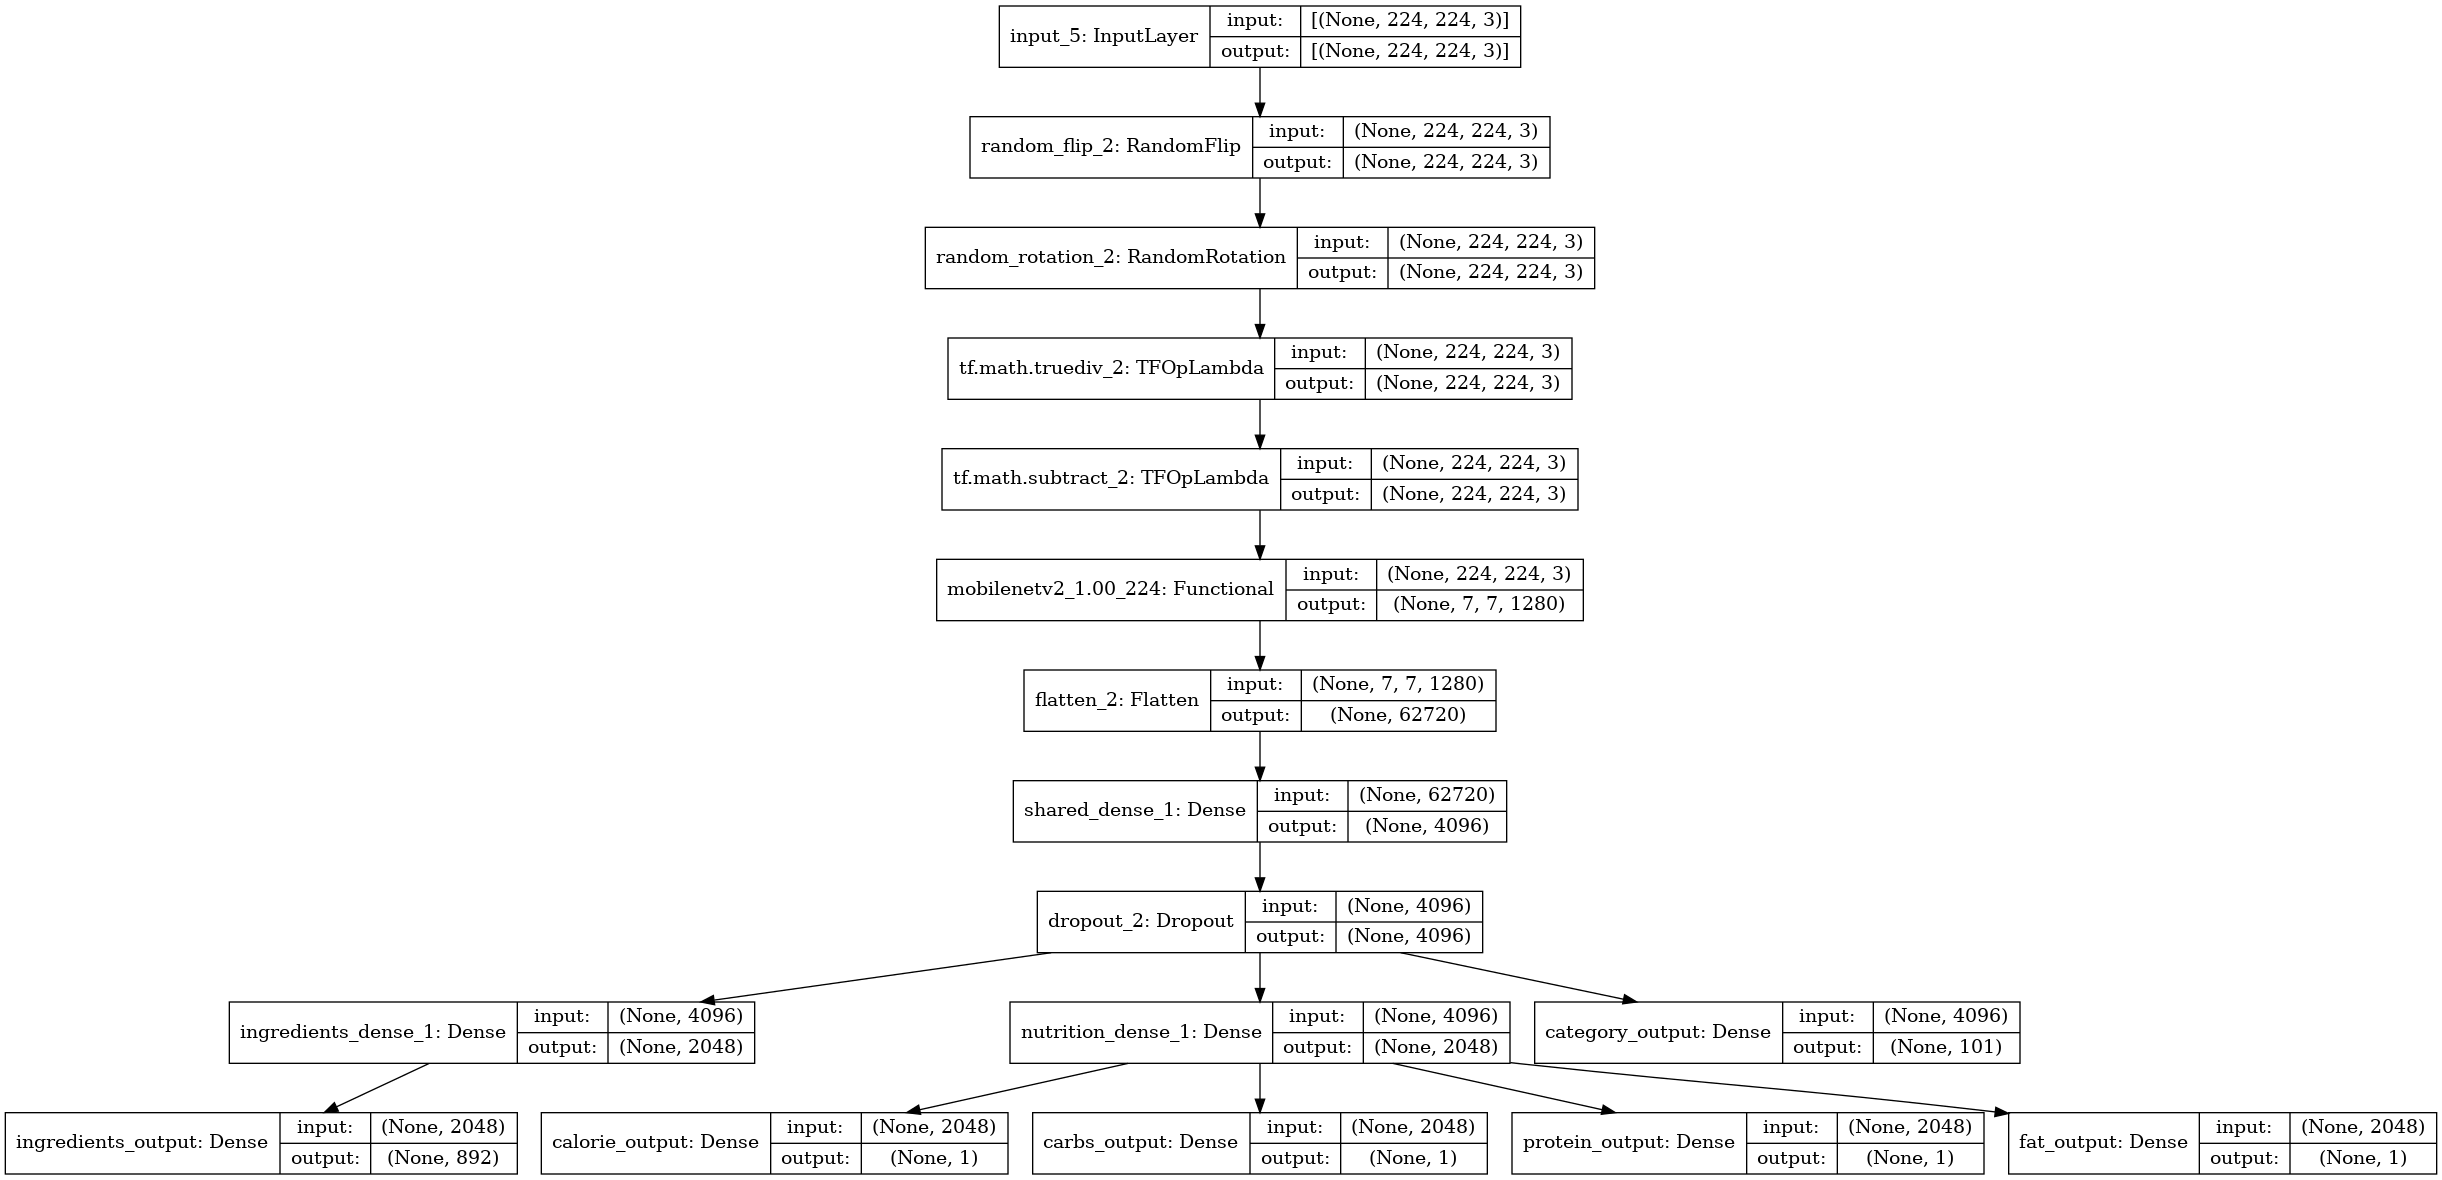

In [14]:
keras.utils.plot_model(flat_foodnet_mobilenetv2.model, "multi_input_and_output_model.png", show_shapes=True)

In [10]:
# model.save_model("./FlatMobileNetv2Model.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [15]:
flat_foodnet_mobilenetv2.model.fit(
    recipes5k.training_dataset,
    epochs=100,
    verbose=1,
    validation_data=recipes5k.validation_dataset,
)

Epoch 1/100
106/106 [==============================] - 27s 215ms/step - loss: 8.1548 - category_output_loss: 4.4050 - ingredients_output_loss: 0.0879 - calorie_output_loss: 1.2596 - carbs_output_loss: 0.6266 - protein_output_loss: 0.8195 - fat_output_loss: 0.9563 - category_output_categorical_accuracy: 0.1199 - category_output_precision_4: 0.2929 - category_output_recall_4: 0.0086 - ingredients_output_top_k_categorical_accuracy: 0.6196 - ingredients_output_precision_5: 0.0466 - ingredients_output_recall_5: 0.1024 - calorie_output_mean_absolute_error: 1.2596 - carbs_output_mean_absolute_error: 0.6266 - protein_output_mean_absolute_error: 0.8195 - fat_output_mean_absolute_error: 0.9563 - val_loss: 4.7450 - val_category_output_loss: 3.4132 - val_ingredients_output_loss: 0.0387 - val_calorie_output_loss: 0.6790 - val_carbs_output_loss: 0.2083 - val_protein_output_loss: 0.1755 - val_fat_output_loss: 0.2303 - val_category_output_categorical_accuracy: 0.2286 - val_category_output_precision_4:

In [ ]:
# remove dropout in shared dense
model.fit(
    recipes5k.training_dataset,
    epochs=10,
    verbose=1,
    validation_data=recipes5k.validation_dataset,
)

In [ ]:
# Remove dropout and replace global average pooling to flatten
model = FlatMobileNetv2Model()
model = model.build_and_compile()
model.summary()

In [ ]:
model.fit(
    recipes5k.training_dataset,
    epochs=10,
    verbose=1,
    validation_data=recipes5k.validation_dataset,
)

## Testing 

In [ ]:
def load_recipe5k_metadata():
    directory = (
        Path("../Food Datasets/final-dataset") / "metadata" / "recipes5k_metadata.csv"
    )
    return pd.read_csv(directory, sep="\t")

In [ ]:
data = load_recipe5k_metadata()

In [ ]:
data.head()

In [ ]:
test_recipes5k = Recipes5k()

In [ ]:
len(test_recipes5k)

In [ ]:
test_gen_func = test_recipes5k.generate_dataset()

In [ ]:
test_dataset = test_recipes5k.get_dataset()

In [ ]:
list(recipes5k.take(1))

In [ ]:
test_model = Model()

In [ ]:
test_model = test_model.build_and_compile()

In [ ]:
test_model.summary()

In [ ]:
test_model.fit(
    x=test_recipes5k.training_dataset,
    epochs=1,
    verbose=1,
    validation_data=test_recipes5k.validation_dataset,
)

In [ ]:
test = tf.constant([[[1, 2, 3]]])

In [ ]:
test.shape

In [ ]:
tf.expand_dims(test, axis=0)

In [ ]:
test_recipes5k.training_dataset

In [ ]:
test_recipes5k.validation_dataset

In [ ]:
row = 0
for x in test_recipes5k.training_dataset:
    row += 1
print(row)